### scmap to compare our gonadal immune cells to fetal bone marrow cells

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(Matrix)
library(scmap)

#### Load data

In [7]:
path_to_FBM = '/nfs/team292/vl6/immune_fetal_gonads/FetalBoneMarrow/'
path_to_atlas = '/nfs/team292/vl6/immune_fetal_gonads/'

In [8]:
fbm = sc.read(path_to_FBM + "bm_plus_19pcw_raw_dr_20201007.h5ad")
fbm

AnnData object with n_obs × n_vars = 103228 × 33712
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold'
    var: 'gene_ids-1', 'feature_types-1'
    obsm: 'X_orig_pca', 'X_pca', 'X_umap'

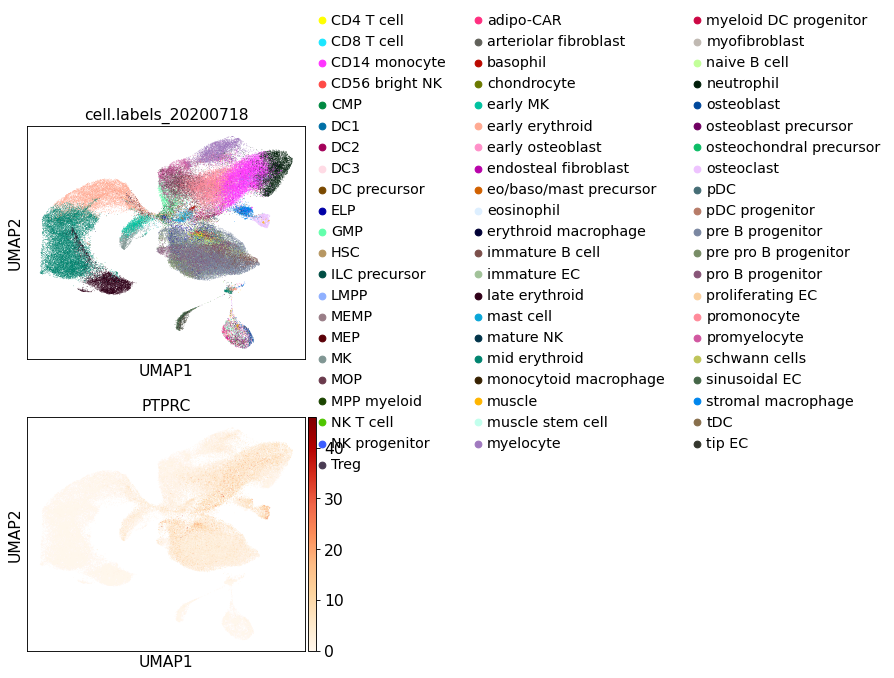

In [9]:
sc.pl.umap(fbm, color = ['cell.labels_20200718', 'PTPRC'], ncols = 1, color_map = 'OrRd')

In [10]:
fbm = anndata.AnnData(X = fbm.raw.X, var = fbm.raw.var, obs = fbm.obs)
fbm.shape

(103228, 33712)

In [11]:
atlas = sc.read(path_to_atlas + 'immune_merged_lineages.h5ad')
atlas.shape

(20556, 21209)

In [12]:
atlas = anndata.AnnData(X = atlas.raw.X, var = atlas.raw.var, obs = atlas.obs)
atlas.shape

(20556, 29052)

#### Intersect genes

In [13]:
fbm_genes = fbm.var_names.to_list()
atlas_genes = atlas.var_names.to_list()

from functools import reduce
inters = reduce(np.intersect1d, (fbm_genes, atlas_genes))
len(inters)

20482

#### Remove cell cycle genes than can bias scmap

In [14]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [x for x in cell_cycle_genes if x in list(inters)]
inters = [x for x in list(inters) if x not in cell_cycle_genes]
len(inters)

20388

In [15]:
fbm = fbm[:, list(inters)]
fbm

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 103228 × 20388
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold'
    var: 'gene_ids-1', 'feature_types-1'

In [16]:
atlas = atlas[:, list(inters)]

#### Downsample more frequent classes for computational efficiency

In [17]:
myindex = fbm.obs['cell.labels_20200718'].value_counts().index 
myvalues = fbm.obs['cell.labels_20200718'].value_counts().values
clusters = pd.Series(myvalues, index = myindex)
clusters.values

array([14297, 14229,  8763,  7474,  7437,  5528,  5427,  4636,  4501,
        3838,  3794,  2191,  1988,  1624,  1464,  1411,  1357,  1281,
        1221,  1000,   712,   705,   648,   598,   550,   456,   449,
         425,   363,   362,   353,   327,   321,   290,   280,   269,
         254,   201,   193,   191,   175,   171,   139,   136,   131,
         111,    92,    92,    92,    83,    80,    78,    67,    62,
          54,    50,    42,    34,    31,    26,    26,    23,    16,
           9])

In [18]:
import random
from itertools import chain

# Find clusters with > n cells
n = 400
cl2downsample = clusters.index[ clusters.values > n ]

# save all barcode ids from small clusters
holder = []
holder.append( fbm.obs_names[[ i not in cl2downsample for i in fbm.obs['cell.labels_20200718'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = fbm[[ i == cl for i in fbm.obs['cell.labels_20200718'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
fbm = fbm[[ i in samples for i in fbm.obs_names ]]
fbm.X.shape

mid erythroid
pre B progenitor
CD14 monocyte
early erythroid
promonocyte
pro B progenitor
pre pro B progenitor
late erythroid
neutrophil
MOP
myelocyte
promyelocyte
immature B cell
early MK
stromal macrophage
naive B cell
ELP
GMP
osteoclast
MK
pDC
DC3
mast cell
DC2
sinusoidal EC
osteoblast precursor
CD56 bright NK
CMP


(16424, 20388)

#### Convert anndata to SingleCellExperiment

In [19]:
%%R -i atlas
atlas

class: SingleCellExperiment 
dim: 20388 20556 
metadata(0):
assays(1): X
rownames(20388): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(256): gene_ids.0.0 feature_types.0.0 ... variances.1
  variances_norm.1
colnames(20556): FCA_GND8047884_CCCATACAGAGATGAG
  FCA_GND8047884_CTTAGGATCAGTGCAT ...
  HCA_F_GON10941969_TTTCCTCTCCTTGACC HCA_F_GON10941969_TTTGGTTCAAGGTTCT
colData names(65): batch batch_collection ... prob_pro.B.cell lineages
reducedDimNames(0):
altExpNames(0):


In [20]:
%%R -i fbm
fbm

class: SingleCellExperiment 
dim: 20388 16424 
metadata(0):
assays(1): X
rownames(20388): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(2): gene_ids.1 feature_types.1
colnames(16424):
  F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AACTCCCCAGTATAAG
  F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AAGGAGCGTGAGTATA ...
  TTTACGTAGCAGCCTC-1-WSSS_F_BON8710643
  TTTCACACATACACCA-1-WSSS_F_BON8710643
colData names(23): cell.labels doublets ... nk_meta mito.threshold
reducedDimNames(0):
altExpNames(0):


#### Feature selection

In [21]:
%%R 

counts <- assay(fbm, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(fbm) <- log2(t(t(counts)/size.factors) + 1)
assayNames(fbm)

[1] "X"         "logcounts"



FALSE  TRUE 
19988   400 


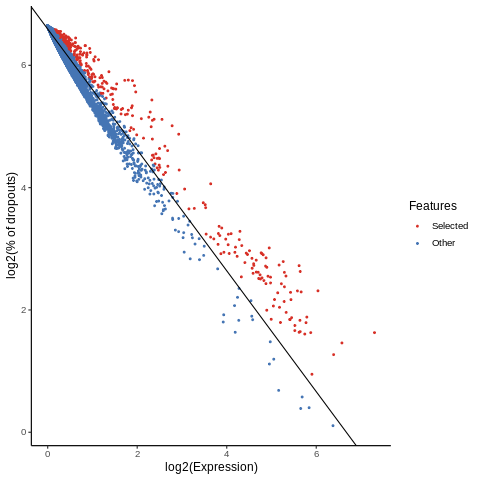

In [22]:
%%R

rowData(fbm)$feature_symbol <- rownames(fbm)
logcounts(fbm) <- as.matrix(logcounts(fbm))
fbm <- selectFeatures(fbm, n_features = 400, suppress_plot = FALSE)
print(table(rowData(fbm)$scmap_features))

### scmap-cluster

      erythroid macrophage DC precursor      ELP monocytoid macrophage
A2M               1.388648     0.000000 0.000000              0.000000
ACP5              0.000000     0.000000 0.000000              0.000000
ACTB              5.508403     6.728568 6.046015              6.885814
ACTG1             4.247850     5.761613 6.311489              4.769449
AHSP              3.887556     0.000000 0.000000              0.000000
AIF1              2.551734     3.673471 3.249788              4.216738
      pre pro B progenitor promonocyte mast cell CD8 T cell       MK       MEP
A2M               0.000000    0.000000  0.000000   0.000000 0.000000 0.0000000
ACP5              0.000000    0.000000  0.000000   0.000000 0.000000 0.0000000
ACTB              6.451660    6.840308  6.379816   6.177958 8.385400 6.0430665
ACTG1             5.628191    5.653848  5.968303   5.264969 5.921369 4.6366459
AHSP              0.000000    0.000000  0.000000   0.000000 0.000000 0.3383885
AIF1              2.215855   

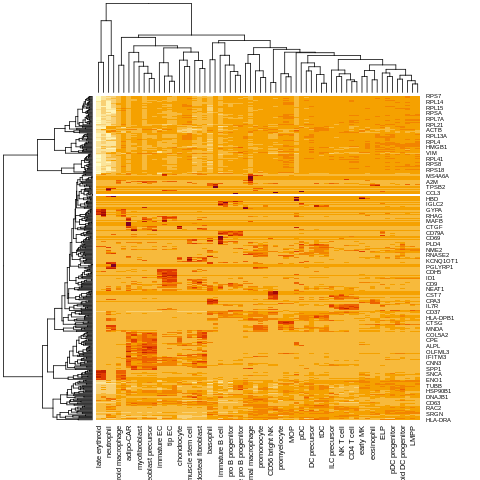

In [23]:
%%R 

fbm <- indexCluster(fbm, cluster_col = 'cell.labels_20200718')
print(head(metadata(fbm)$scmap_cluster_index))
heatmap(as.matrix(metadata(fbm)$scmap_cluster_index))

#### Projection

In [24]:
%%R 

rowData(atlas)$feature_symbol <- rownames(atlas)
counts <- assay(atlas, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(atlas) <- log2(t(t(counts)/size.factors) + 1)
logcounts(atlas) <- as.matrix(logcounts(atlas))
assayNames(atlas)

[1] "X"         "logcounts"


In [25]:
%%R -o scmapCluster_results

scmapCluster_results <- scmapCluster(
  projection = atlas, 
  index_list = list(
    fbm = metadata(fbm)$scmap_cluster_index
  )
)

In [26]:
%%R 

print(head(scmapCluster_results$scmap_cluster_labs))
print(head(scmapCluster_results$scmap_cluster_siml))
print(head(scmapCluster_results$combined_labs))

     fbm                 
[1,] "early MK"          
[2,] "stromal macrophage"
[3,] "DC2"               
[4,] "DC1"               
[5,] "stromal macrophage"
[6,] "promonocyte"       
           fbm
[1,] 0.8891455
[2,] 0.9064194
[3,] 0.9693557
[4,] 0.9475017
[5,] 0.9422120
[6,] 0.9477545
[1] "early MK"           "stromal macrophage" "DC2"               
[4] "DC1"                "stromal macrophage" "promonocyte"       


In [27]:
labels = list(scmapCluster_results[0])

In [28]:
atlas.obs['scmap_FetalBoneMarrow'] = labels
atlas.obs['scmap_FetalBoneMarrow'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


stromal macrophage        8635
CD14 monocyte             1530
CD56 bright NK            1464
DC2                       1268
naive B cell               651
DC1                        623
pro B progenitor           567
unassigned                 527
pre B progenitor           394
monocytoid macrophage      367
neutrophil                 340
pre pro B progenitor       331
promonocyte                278
mature NK                  262
osteoclast                 261
MEMP                       236
myeloid DC progenitor      233
NK progenitor              221
DC3                        208
NK T cell                  202
LMPP                       185
MK                         178
MEP                        175
myelocyte                  161
pDC                        135
mast cell                  117
tDC                        100
promyelocyte                98
MOP                         91
CD4 T cell                  84
CD8 T cell                  82
ILC precursor               74
Treg    

In [29]:
similarities = scmapCluster_results[1]
similarities = [val for sublist in similarities for val in sublist]
#similarities

In [30]:
atlas.obs['scmap_similarities_FetalBoneMarrow'] = similarities

#### Save scmap results 

In [31]:
atlas.obs[['scmap_FetalBoneMarrow', 'scmap_similarities_FetalBoneMarrow']].to_csv(path_to_atlas + 'scmap_from_FetalBoneMarrow.csv')